# Setup

In [2]:
import numpy as np
from scipy.special import eval_legendre, legendre, spherical_jn
import itertools
import time
from itertools import cycle
from math import atan2,degrees,lgamma 
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from scipy.optimize import fsolve
from scipy.interpolate import RegularGridInterpolator
import random
import os 
import seaborn as sns

import matplotlib.pyplot as plt

import hmvec as hm

In [3]:
############# Define constants ################
# From hmvec:
# proper radius r is always in Mpc
# comoving momentum k is always in Mpc-1
# All masses m are in Msolar
# rho densities are in Msolar/Mpc^3
# No h units anywhere

TFIRAS   = 2.725
TCMB     = 2.725*1e6
cmMpc    = 3.2407792896e-25    # Mpc/cm            # how many Mpc in a cm
eVinvCm  = 1.97*1e-5  #1.2398419e-4        # cm/eV^-1          # how many cm in a eV^-1
mpcEVinv = 1./(cmMpc*eVinvCm)  # eV^-1/Mpc         # how many eV^-1 in a Mpc

msun   = 1.9891e30     # kg               # Sun mass
mprot  = 1.67262e-27   # kg               # Proton mass
m2eV   = 1.4e-21       # eV^2             # conversion factor for plasma mass (eq. (2) in Caputo et al; PRL)
ombh2  = 0.02225                 # Physical baryon density parameter Ωb h2
omch2  = 0.1198                  # Physical dark matter density parameter Ωc h2
conv   = m2eV*(ombh2/omch2)*(msun/mprot)*(cmMpc)**3.

thomson = 0.6652*1e-24
conv2 = thomson*(ombh2/omch2)*(msun/mprot)*(cmMpc)**2.

ev2Joule = lambda ev: 1.602176565*1e-19*ev
K2eV = lambda K: 8.61732814974493*1e-5*K
cligth = 299792458.0 #m/s
hplanck = 6.62607015*1e-34 # m2 kg / s
kboltzmann = 1.380649*1e-23 # m2 kg s-2 K-1
gauss2evsq = lambda gauss: 1.95e-2 * gauss
frq = lambda nu: 100. * nu * cligth

BBf = lambda frq: 1e26/1e6*(2.*frq**3.*hplanck)/cligth**2. / (np.exp(hplanck*frq/kboltzmann/TFIRAS) - 1.)
BBω = lambda omg: (omg**3.)/(2.*np.pi**2.) / (np.exp(omg/K2eV(TFIRAS)) - 1.)

aa = lambda z: 1./(1.+z)

arcmin2rad = lambda arcm: arcm/60. * np.pi/180.
ghztoev    = lambda GHz: 4.13566553853809E-06 * GHz


In [4]:
# you can ignore this one box

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

from mpl_toolkits.axes_grid1 import make_axes_locatable

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e'%x))
fmt = mticker.FuncFormatter(g)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

plt.rcParams.update({'backend' : 'Qt5Agg'})
plt.rcParams.update({'text.usetex' : True})

plt.rcParams.update({'font.size' : 15.0})
plt.rcParams.update({'axes.titlesize' : 20.0})  # Font size of title
plt.rcParams.update({'axes.titlepad'  : 10.0})
plt.rcParams.update({'axes.labelsize' : 20.0})  # Axes label sizes
plt.rcParams.update({'axes.labelpad'  : 10.0})
plt.rcParams.update({'xtick.labelsize'  : 20.0})
plt.rcParams.update({'ytick.labelsize'  : 20.0})
#plt.rcParams.update({'xtick.labelsize'  : 10.0})
#plt.rcParams.update({'ytick.labelsize'  : 10.0})

plt.rcParams.update({'axes.spines.left'  : True})
plt.rcParams.update({'axes.spines.right'  : True})
plt.rcParams.update({'axes.spines.top'  : True})
plt.rcParams.update({'axes.spines.bottom'  : True})
plt.rcParams.update({'savefig.format'     : 'pdf'})
plt.rcParams.update({'savefig.bbox'       : 'tight'})
plt.rcParams.update({'savefig.pad_inches' : 0.1})
plt.rcParams.update({'pdf.compression' : 6})

def plot_dmdz(ms, zs, func, count=10, title='No Title'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    c1, c2, g1, g2 = 0, 0, 0, 0
    for mi, mm in enumerate(ms):
        if mm in ms[:count]:
            ax[0].plot(zs, func[:,mi], linewidth=1, label=('$m=${}'.format(fmt(mm)) if mm in ms[:count//count] else None), alpha=1-c1/count, color='k')
            c1 += 1
        elif mm in ms[-count:]:
            ax[0].plot(zs, func[:,mi], linewidth=1, label=('$m=${}'.format(fmt(mm)) if mm in ms[-count//count:] else None), alpha=c2/count, color='g')
            c2 += 1
    for zi, zz in enumerate(zs):
        if zz in zs[:count]:
            ax[1].plot(ms, func[zi,:], linewidth=1, label=('$z=${}'.format(fmt(zz)) if zz in zs[:count//count] else None), alpha=1-g1/count, color='r')
            g1 += 1
        elif zz in zs[-count:]:
            ax[1].plot(ms, func[zi,:], linewidth=1, label=('$z=${}'.format(fmt(zz)) if zz in zs[-count//count:] else None), alpha=g2/count, color='b')
            g2 += 1

    ax[0].set_xlabel(r'$z$')
    ax[1].set_xlabel(r'$m$')
    for axx in ax:
        axx.set_yscale('log')
        axx.set_xscale('log')
        axx.set_ylabel(title)
        axx.legend(loc='best'); axx.grid()
    return ax

def plot_ucosth(ms, zs, angs, ucosth, prob, title, count=10):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    nMs, nZs = len(ms), len(zs)
    c1, c2, g1, g2 = 0, 0, 0, 0
    for mi, mm in enumerate(ms):
        if mm in ms[:count]:
            lab = lambda zi: (r'$m=${}'.format(fmt(mm))+f', $z=%5.2f$'%(zs[zi]) if mi==0 else None)
            zi = 0
            ax[0].plot(angs[:,zi,mi], ucosth[:,zi,mi], label=lab(zi), alpha=1-c1/count, color='k')
            c1 += 1
            zi = nZs-1
            ax[0].plot(angs[:,zi,mi], ucosth[:,zi,mi], label=lab(zi), alpha=1-c2/count, color='r')
            c2 += 1
        elif mm in ms[-count:]:
            lab = lambda zi: (r'$m=${}'.format(fmt(mm))+f', $z=%5.2f$'%(zs[zi]) if mi==len(ms)-1 else None)
            zi = 0
            ax[0].plot(angs[:,zi,mi], ucosth[:,zi,mi], label=lab(zi), alpha=g1/count, color='g')
            g1 += 1
            zi = nZs-1
            ax[0].plot(angs[:,zi,mi], ucosth[:,zi,mi], label=lab(zi), alpha=g2/count, color='b')
            g2 += 1

    c1, c2, g1, g2 = 0, 0, 0, 0
    for mi, mm in enumerate(ms):
        if mm in ms[:count]:
            lab = lambda zi: (r'$m=${}'.format(fmt(mm))+f', $z=%5.2f$'%(zs[zi]) if mi==0 else None)
            zi = 0
            ax[1].plot(angs[:,zi,mi], ucosth[:,zi,mi]*prob[zi,mi], label=lab(zi), alpha=1-c1/count, color='k')
            c1 += 1
            zi = nZs-1
            ax[1].plot(angs[:,zi,mi], ucosth[:,zi,mi]*prob[zi,mi], label=lab(zi), alpha=1-c2/count, color='r')
            c2 += 1
        elif mm in ms[-count:]:
            lab = lambda zi: (r'$m=${}'.format(fmt(mm))+f', $z=%5.2f$'%(zs[zi]) if mi==len(ms)-1 else None)
            zi = 0
            g1 += 1
            ax[1].plot(angs[:,zi,mi], ucosth[:,zi,mi]*prob[zi,mi], label=lab(zi), alpha=g1/count, color='g')
            zi = nZs-1
            ax[1].plot(angs[:,zi,mi], ucosth[:,zi,mi]*prob[zi,mi], label=lab(zi), alpha=g2/count, color='b')
            g2 += 1

    for axx in ax:
        axx.set_yscale('log')
        axx.set_xscale('log')
        axx.set_ylabel(r'$u(\cos(\theta)) \times Prob$')
        axx.set_xlabel(r'$\theta$')
        axx.legend(loc='best'); axx.grid()
    return ax


# Functions

In [5]:
# Functions to compute the useful stuff

get_volume_conv = lambda chis, Hz: chis**2. / Hz

def get_rcross_per_halo(zs, ms, rs, rvir, rhocritz, deltav, cs, MA, name='battagliaAGN'):
    
    """ Compute crossing radius of each halo
    i.e. radius where plasma mass^2 = dark photon mass^2
    Find the index of the radius array where plasmon mass^2 = dark photon mass^2 """

    m200critz, r200critz = get_200critz(zs, ms, cs, rhocritz, deltav)
    rcross_res = np.zeros((len(zs), len(ms)))
    
    for i_z, z in enumerate(zs):
        for i_m, m in enumerate(ms):
            def func(x):
                return np.abs(conv*get_gas_profile(x, z, m200critz[i_z, i_m], r200critz[i_z, i_m], rhocritz[i_z])/MA**2. - 1)
            rcross_res[i_z, i_m] = fsolve(func, x0=rs[0])

    return rcross_res

def R_from_M(M,rho,delta):
    ''' Gives you halo radius from mass and overdensity'''
    return (3.*M/4./np.pi/delta/rho)**(1./3.) 

def get_200critz(zs, ms, cs, rhocritz, deltav):
    delta_rhos1 = deltav*rhocritz
    delta_rhos2 = 200.*rhocritz
    m200critz = hm.mdelta_from_mdelta(ms, cs, delta_rhos1, delta_rhos2)
    r200critz = R_from_M(m200critz, rhocritz[:,None], delta=200.)
    return m200critz, r200critz

def get_gas_profile(rs, zs, m200, r200, rhocritz):
    rho0, alpha, beta, gamma, xc = battagliaAGN(m200, zs)
    rho = rhocritz * rho0
    x = rs/r200/xc
    expo = -(beta+gamma)/alpha     # gamma sign must be opposite from Battaglia/ACT paper; typo

    return rho * (x**gamma) * ((1.+x**alpha)**expo)

def battagliaAGN(m200, zs):
    # power law fits:
    rho0  = 4000. * (m200/1e14)**0.29    * (1.+zs)**(-0.66)
    alpha = 0.88  * (m200/1e14)**(-0.03) * (1.+zs)**0.19
    beta  = 3.83  * (m200/1e14)**0.04    * (1.+zs)**(-0.025)
        
    gamma = -0.2
    xc    = 0.5
    return rho0, alpha, beta, gamma, xc

#def conv_prob(zs, rvir, MA, rcross):
#    omgz   = (1.+zs[:,None])# * omega0 but we want to keep frequency dependence separate
#    uang  = 2.*np.heaviside(rvir - rcross, 0.5)
#    return mpcEVinv * rcross * uang * omgz / MA**2.

def old_conv_prob(zs, ms, rs, rvir, rhocritz, deltav, cs, MA, rcross):
    m200, r200 = get_200critz(zs, ms, cs, rhocritz, deltav)
    drhodr = get_deriv_gas_profile(rcross, zs[:,None], m200, r200, rhocritz[:,None])
    dmdr   = np.abs(conv*drhodr)
    omgz   = (1.+zs[:,None])# * omega0 but we want to keep frequency dependence separate
    uang   = 2.*np.heaviside(rvir - rcross, 0.5)
    return mpcEVinv * uang * omgz / dmdr

def conv_prob(zs, ms, rs, rvir, rhocritz, deltav, cs, MA, rcross):
    """Conversion probability including the B field profile"""
    m200, r200 = get_200critz(zs, ms, cs, rhocritz, deltav)
    drhodr = get_deriv_gas_profile(rcross, zs[:,None], m200, r200, rhocritz[:,None])
    dmdr   = np.abs(conv*drhodr)
    omgz   = (1.+zs[:,None])# * omega0 but we want to keep frequency dependence separate
    uang   = 2.*np.heaviside(rvir - rcross, 0.5)
    
    bprof = get_B_rcross(zs, ms, m200, r200, rhocritz, rcross)
    
    return mpcEVinv * uang * bprof**2 * omgz / dmdr

def conv_prob_flat(zs, ms, rs, rvir, rhocritz, deltav, cs, MA, rcross):
    """Conversion probability including the B field profile"""
    m200, r200 = get_200critz(zs, ms, cs, rhocritz, deltav)
    drhodr = get_deriv_gas_profile(rcross, zs[:,None], m200, r200, rhocritz[:,None])
    dmdr   = np.abs(conv*drhodr)
    omgz   = (1.+zs[:,None])# * omega0 but we want to keep frequency dependence separate
    uang   = 2.*np.heaviside(rvir - rcross, 0.5)
    
    bprof = get_B_rcross_flat(zs, ms, m200, r200, rhocritz, rcross)
    
    return mpcEVinv * uang * bprof**2 * omgz / dmdr


def get_deriv_gas_profile(rs, zs, m200, r200, rhocritz):
    rho0, alpha, beta, gamma, xc = battagliaAGN(m200, zs)
    x = rs / r200 / xc
    P = rhocritz * rho0
    expo = -(alpha+beta+gamma)/alpha
    drhodr = P * (x**gamma) * (1. + x**alpha)**expo * (gamma - x**alpha * beta) / rs

    if hasattr(rs, "__len__"): drhodr[rs==0.] = 0.
    elif rs==0: drhodr = 0.
    return drhodr

def get_u00(angs, ucosth):
    # angular function u(theta) projected into multipoles
    cos_angs = np.cos(angs)
    Pell     = eval_legendre(0, cos_angs)
    integr   = Pell * np.sin(angs) * ucosth
    uL0      = 2.*np.pi * np.trapz(integr, angs, axis=0)
    return uL0 * (4.*np.pi)**(-0.5)

def get_avtau(zs, ms, nzm, dvol, prob00):
    # Average optical depth per redshift bin
    dtaudz = np.trapz(nzm * prob00, ms, axis=-1) * dvol * 4*np.pi
    avtau  = np.trapz(dtaudz, zs, axis=0)
    return avtau, dtaudz

def get_halo_skyprofile(zs, chis, rcross):
    # get theta coordinate bounds within each halo
    rchis = chis*aa(zs)
    fract = (rcross/rchis[:,None])[None,...]

    # choose how many points to sample:
    nsamp = 71
    listincr = 1. - np.geomspace(1e-3, 1., nsamp)
    listincr = np.asarray([1.] + listincr.tolist())[::-1]
    angs = listincr[:,None,None] * fract

    ucosth = (1.-(angs/fract)**2.)**(-0.5)
    ucosth[angs == fract] = 0.
    return ucosth, angs

In [6]:
def get_pth_profile(rs, zs, m200, r200, rhocritz):  # Eq. (17) from ACT https://arxiv.org/pdf/2009.05558.pdf
    xct = 0.497 * (m200/1e14)**(-0.00865) * (1.+zs)**0.731
    x = rs/r200
    gammat = -0.3
    P0 = 2
    alphat = 0.8
    betat = 2.6
    fb = 0.044/0.25
    
    PGNFW = P0 * (x/xct)**gammat * ( 1 + (x/xct)**alphat )**(-betat)
    P200 = m200*200*rhocritz*fb/(2*r200)    # this has an additional factor of G in front, but we don't care about the units since this is only for modeling the B field profile
    
    return PGNFW*P200


def get_B_rcross(zs, ms, m200c, r200c, rhocritz, rcross):
    
    rcross_ratio = rcross/r200c
    Brcross = np.zeros((len(zs), len(ms)))
    
    ms_ind = np.digitize(m200c[0, :], mass_bins)
    ms_ind[ms_ind == len(logB_interp_list)] = len(logB_interp_list)-1

    for i_m in range(len(ms)):
        for i_z, z_val in enumerate(zs):        
            if rcross_ratio[i_z, i_m] < rad_bins[0]:
                Brcross[i_z, i_m] = ( get_pth_profile(rcross_ratio[i_z, i_m]*r200c[i_z, i_m], z_val, m200c[i_z, i_m], r200c[i_z, i_m], rhocritz[i_z]) /
                                      get_pth_profile(rad_bins[0]*r200c[i_z, i_m], z_val, m200c[i_z, i_m], r200c[i_z, i_m], rhocritz[i_z]) ) * 10**logB_interp_list[ms_ind[i_m]]( [np.log10(z_val), rad_bins[0]] )   
            else:
                Brcross[i_z, i_m] = 10**logB_interp_list[ms_ind[i_m]]( [np.log10(z_val), rcross_ratio[i_z, i_m] ] )     
                
    return Brcross

def get_B_rcross_flat(zs, ms, m200c, r200c, rhocritz, rcross):
    
    rcross_ratio = rcross/r200c
    Brcross = np.zeros((len(zs), len(ms)))
    
    ms_ind = np.digitize(m200c[0, :], mass_bins)
    ms_ind[ms_ind == len(logB_interp_list)] = len(logB_interp_list)-1

    for i_m in range(len(ms)):
        for i_z, z_val in enumerate(zs):        
            if rcross_ratio[i_z, i_m] < rad_bins[0]:
                Brcross[i_z, i_m] = 10**logB_interp_list[ms_ind[i_m]]( [np.log10(z_val), rad_bins[0]] )   
            else:
                Brcross[i_z, i_m] = 10**logB_interp_list[ms_ind[i_m]]( [np.log10(z_val), rcross_ratio[i_z, i_m] ] )     
                
    return Brcross

# Import the B field profiles

In [41]:
# See Table 1 of 2309.13104 for the halo properties for the given mass bins
file_names = ['profile_bfld_halo_1e10_h12.txt', 'profile_bfld_halo_1e10_h11.txt', 'profile_bfld_halo_1e11_h10.txt', 
              'profile_bfld_halo_1e11_h4.txt', 'profile_bfld_halo_1e12_h12.txt', 'profile_bfld_halo_1e13_h4.txt', 
              'profile_bfld_halo_1e13_h8.txt']
# file_names = ['profile_bfld_halo_'+str(i+1)+'.txt' for i in range(7)]# os.listdir('./data/bfield_profiles/')
mass_bins = 10**np.array([9.9, 10.4, 10.9, 11.4, 12, 12.5, 13])

In [42]:
# Radial bins are the same for all of the files
rad_bins = np.genfromtxt('./data/bfield_profiles/'+file_names[0], skip_header=3, max_rows=1)
rad_bins_c = rad_bins[:-1]+(rad_bins[1:]-rad_bins[:-1])/2

Bfiled_grid = np.zeros((len(mass_bins), 66, 23))
logB_interp_list = []

for i, file in enumerate(file_names):
    Bfiled_grid[i] = np.genfromtxt('./data/bfield_profiles/'+file_names[i], skip_header=7).astype(float)
#    logB_interp_list.append(RegularGridInterpolator((np.log10(Bfiled_grid[i][:, 0]), rad_bins_c), np.log10(Bfiled_grid[i][:, 3:]*1E6),
#                                                    bounds_error=False, fill_value=-10 ))

    logB_interp_list.append(RegularGridInterpolator((np.log10(np.concatenate( (Bfiled_grid[i][::8, 0], Bfiled_grid[i][-1:, 0]) )), rad_bins_c), 
                                                     np.log10(np.concatenate( (Bfiled_grid[i][::8, 3:], Bfiled_grid[i][-1:, 3:]) )*1E6), 
                                                     bounds_error=False, fill_value=-10 ))

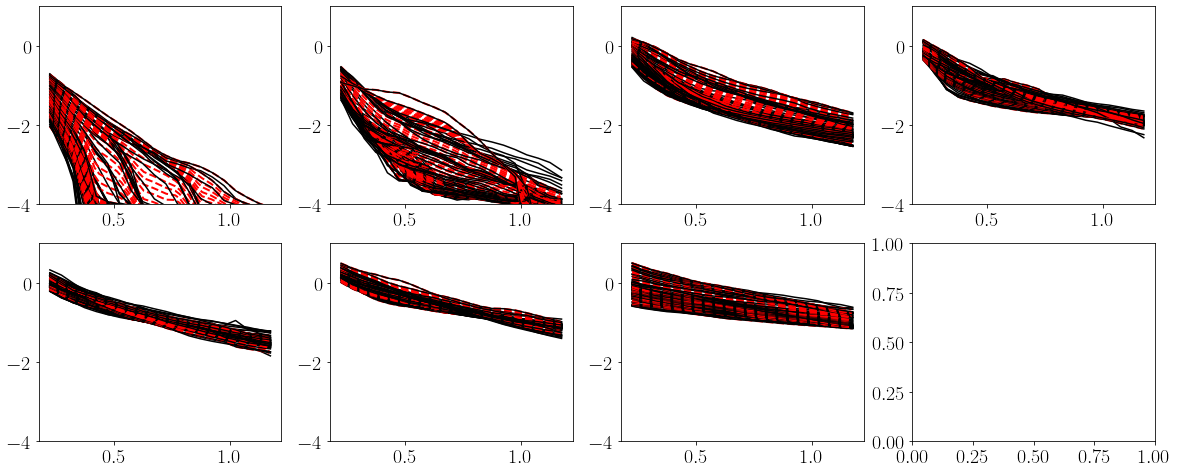

In [45]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
z_val = 0.1
z_list = Bfiled_grid[0][:, 0] #np.geomspace(1e-3, 2, 100) #[1E-6, 0.003, 0.02, 0.05, 0.1, 0.456, 0.8, 0.997, 1.3, 1.9]
r_list = np.linspace(0.225, 1.17, 50)

for i_m in range(len(mass_bins)):

    for z_val in z_list:
        
        pts = np.array([np.full(50, np.log10(z_val)), r_list]).T        
        z_row = np.abs(Bfiled_grid[i_m][:, 0]-z_val).argmin() # np.digitize(z_val, Bfiled_grid[i_m][:, 0]) 
    
        row_i = int(i_m/4); col_i = i_m%4

        ax[row_i][col_i].plot(r_list, logB_interp_list[i_m](pts), linewidth=2, ls='--', color='r')
        ax[row_i][col_i].plot(rad_bins_c, np.log10(Bfiled_grid[i_m][z_row, 3:]*1E6), color='k')
        
        ax[row_i][col_i].set_ylim(-4, 1)

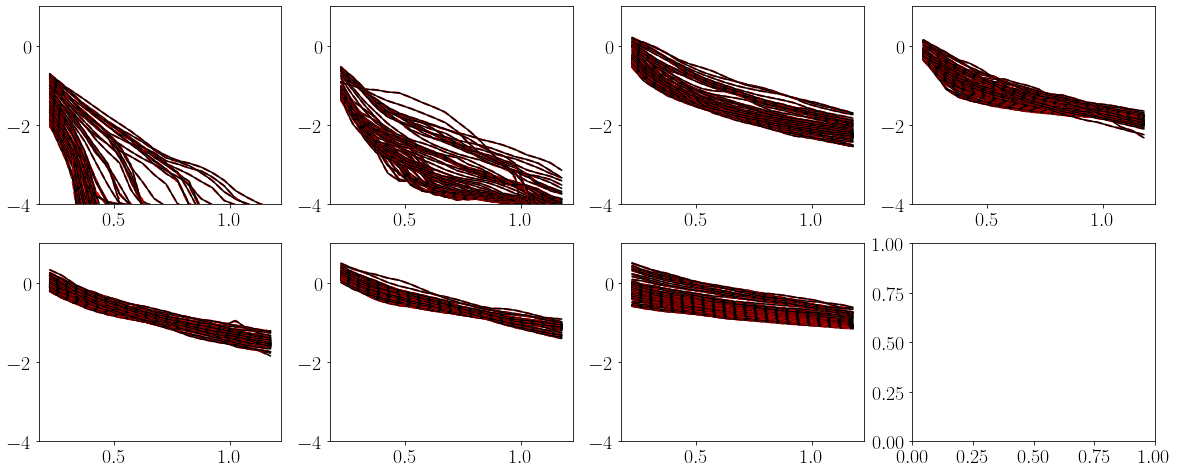

In [9]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
z_val = 0.1
z_list = Bfiled_grid[0][:, 0] #np.geomspace(1e-3, 2, 100) #[1E-6, 0.003, 0.02, 0.05, 0.1, 0.456, 0.8, 0.997, 1.3, 1.9]
r_list = np.linspace(0.225, 1.17, 50)

for i_m in range(len(mass_bins)):

    for z_val in z_list:
        
        pts = np.array([np.full(50, np.log10(z_val)), r_list]).T        
        z_row = np.abs(Bfiled_grid[i_m][:, 0]-z_val).argmin() # np.digitize(z_val, Bfiled_grid[i_m][:, 0]) 
    
        row_i = int(i_m/4); col_i = i_m%4

        ax[row_i][col_i].plot(r_list, logB_interp_list[i_m](pts), linewidth=2, ls='--', color='r')
        ax[row_i][col_i].plot(rad_bins_c, np.log10(Bfiled_grid[i_m][z_row, 3:]*1E6), color='k')
        
        ax[row_i][col_i].set_ylim(-4, 1)

In [46]:
# how many bins of each: mass, redshift, wavenumber
# to speed things up, you can choose smaller numbers
nKs = 1001

# geomspace divides the interval logarithmically and linspace linearly
ms  = (mass_bins*1.16).copy()                   # all masses
zs  = Bfiled_grid[0, ::10, 0]              # all redshifts
ks  = np.geomspace(1e-4, 1e3, nKs)       # all wavenumbers

# Halo Model
hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')

In [47]:
# Useful halo model quantities:

chis     = hcos.comoving_radial_distance(zs)
rvirs    = np.asarray([hcos.rvir(ms,zz) for zz in zs])
cs       = hcos.concentration()
Hz       = hcos.h_of_z(zs)
nzm      = hcos.get_nzm()
biases   = hcos.get_bh()
deltav   = hcos.deltav(zs)
rhocritz = hcos.rho_critical_z(zs)

In [48]:
m200c, r200c = get_200critz(zs, ms, cs, rhocritz, deltav)
mass_bins/m200c[0]

array([0.99625421, 1.00258254, 1.00936331, 1.01663448, 1.02606549,
       1.03456557, 1.04370056])

In [49]:
Bprof_pth = np.zeros((len(zs), len(ms), len(rad_bins_c)))
Bprof_sqrtpth = np.zeros((len(zs), len(ms), len(rad_bins_c)))
Bfiled_auriga = np.zeros((len(zs), len(ms), len(rad_bins_c)))
rvir_over_r200c = np.zeros((len(zs), len(ms)))

for i_m in range(len(ms)):
    for i_z, z_val in enumerate(zs):
        
        rvir_over_r200c[i_z, i_m] = rvirs[i_z, i_m]/r200c[i_z, i_m]
        
        Bprof_pth[i_z, i_m, :] = ( get_pth_profile(rad_bins_c*r200c[i_z, i_m], z_val, m200c[i_z, i_m], r200c[i_z, i_m], rhocritz[i_z]) / 
                                   get_pth_profile(r200c[i_z, i_m], z_val, m200c[i_z, i_m], r200c[i_z, i_m], rhocritz[i_z]) ) * 10**logB_interp_list[i_m]([np.log10(z_val), 1] )   
        
        Bprof_sqrtpth[i_z, i_m, :] = ( get_pth_profile(rad_bins_c*r200c[i_z, i_m], z_val, m200c[i_z, i_m], r200c[i_z, i_m], rhocritz[i_z]) /  
                                       get_pth_profile(r200c[i_z, i_m], z_val, m200c[i_z, i_m], r200c[i_z, i_m], rhocritz[i_z]) )**(0.5) * 10**logB_interp_list[i_m]( [np.log10(z_val), 1] )   
        
        pts = np.array([np.full(len(rad_bins_c), np.log10(z_val)), rad_bins_c]).T  
        Bfiled_auriga[i_z, i_m, :] = 10**logB_interp_list[i_m](pts)

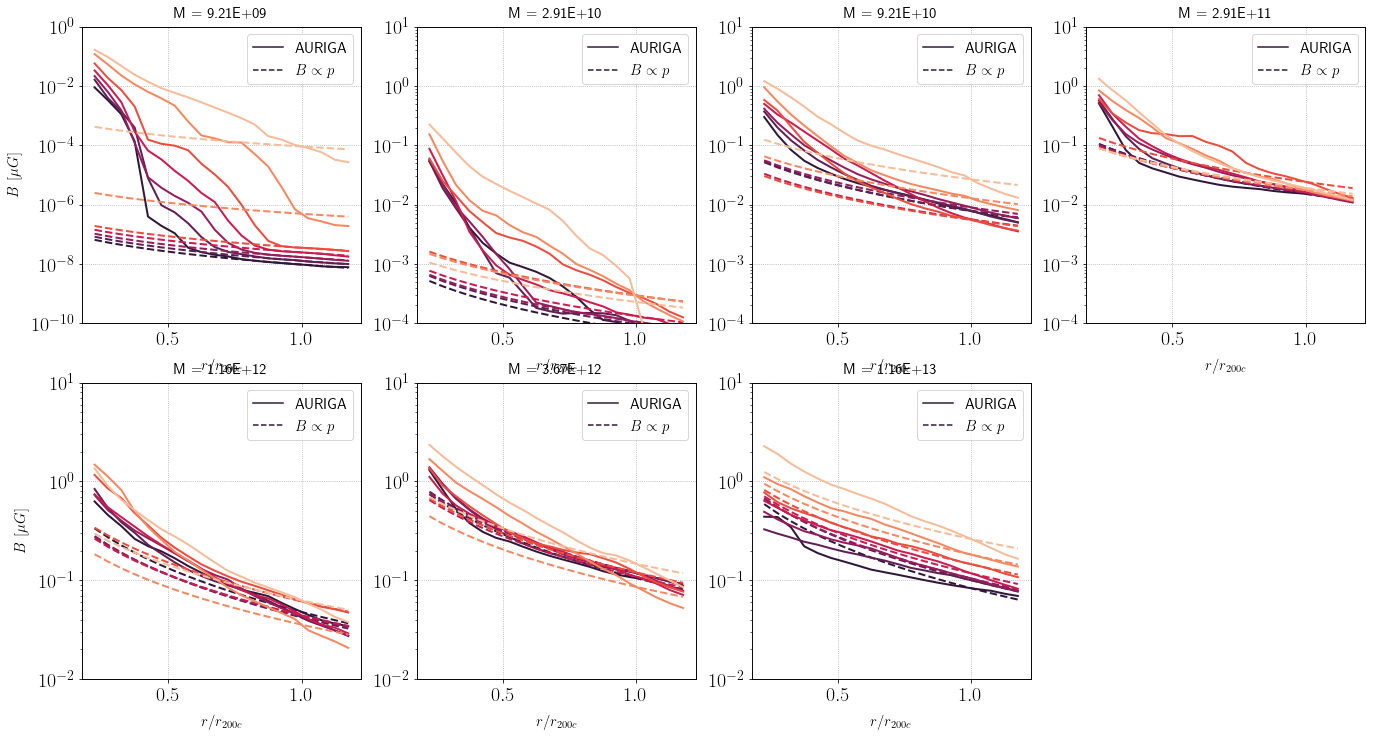

In [50]:
fig, ax = plt.subplots(2, 4, figsize=(23, 12))
color_list = sns.color_palette("rocket", len(zs))

for i_m in range(len(mass_bins)):
    row_i = int(i_m/4); col_i = i_m%4
       
    for i_z, z_val in enumerate(zs):
        
        ax[row_i][col_i].plot(rad_bins_c, Bprof_pth[i_z, i_m, :], color=color_list[i_z], linewidth=2, ls='--')
        #ax[row_i][col_i].plot(rad_bins_c, Bprof_sqrtpth[i_z, i_m, :], color=color_list[i_z], linewidth=2, ls='-.')
        ax[row_i][col_i].plot(rad_bins_c, Bfiled_auriga[i_z, i_m, :], color=color_list[i_z], linewidth=2, ls='-')
        #ax[row_i][col_i].vlines(rvir_over_r200c[i_z, i_m], 0, 10, linewidth=0.5, color=color_list[i_z], alpha=1)

    ax[row_i][col_i].set_yscale('log')
    ax[0][0].set_ylim(1E-10, 1)
    ax[0][col_i].set_ylim(0.0001, 10)
    ax[1][col_i].set_ylim(0.01, 10)
    ax[row_i][col_i].set_xlabel(r'$r/r_{200c}$', fontsize=15); ax[row_i][0].set_ylabel(r'$B\ [\mu G]$', fontsize=15);
    ax[row_i][col_i].set_title('M = '+"{:.2E}".format(ms[i_m]), fontsize=15 )
    ax[row_i][col_i].grid(ls=':', color='darkgray', alpha=1)
    
    ax2 = ax[row_i][col_i].twinx()
    ax2.plot(np.NaN, np.NaN, ls='-', label=r'AURIGA', c=color_list[0])
    ax2.plot(np.NaN, np.NaN, ls='--', label=r'$B \propto p$', c=color_list[0])
    ax2.get_yaxis().set_visible(False)
    ax2.legend(loc='upper right')

    
ax[1, 3].set_visible(False)

# Compute Tau

In [51]:
# Select axion mass in eV
MA = 1e-12

# choose redshift range:
zMin, zMax = 1e-6, np.max(Bfiled_grid[0, :, 0]) #0.005, 6.

# rmin and rmax are the radial limits to scan over in each halo
# need to make sure crossing radius is within these limits
rMin, rMax = 1e-6, 5e1

In [52]:
np.max(Bfiled_grid[0, :, 0])

1.90409

In [53]:
# how many bins of each: mass, redshift, wavenumber
# to speed things up, you can choose smaller numbers
nMs = 100
nZs = 200
nKs = 1001

# geomspace divides the interval logarithmically and linspace linearly
ms  = np.geomspace(0.5e10, 1e17, nMs)      # all masses
zs  = np.linspace(zMin, zMax, nZs)       # all redshifts
rs  = np.linspace(rMin, rMax, 100000)    # halo radial coords
ks  = np.geomspace(1e-4, 1e3, nKs)       # all wavenumbers

# Halo Model
hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')

In [54]:
# Useful halo model quantities:

chis     = hcos.comoving_radial_distance(zs)
rvirs    = np.asarray([hcos.rvir(ms,zz) for zz in zs])
cs       = hcos.concentration()
Hz       = hcos.h_of_z(zs)
nzm      = hcos.get_nzm()
biases   = hcos.get_bh()
deltav   = hcos.deltav(zs)
rhocritz = hcos.rho_critical_z(zs)

In [55]:
dvols  = get_volume_conv(chis, Hz)

In [56]:
def get_tau_ma(MA):
    
    # crossing radius in each halo:
    rcross = get_rcross_per_halo(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA)
    ucosth, angs = get_halo_skyprofile(zs, chis, rcross)
    u00 = get_u00(angs, ucosth)
    
    prob = conv_prob(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA, rcross)
    prob00 = prob * u00

    avtau, dtaudz = get_avtau(zs, ms, nzm, dvols, prob00)
    
    del prob, prob00
    
    prob = conv_prob_flat(zs, ms, rs, rvirs, rhocritz, deltav, cs, MA, rcross)
    prob00 = prob * u00

    avtau_flat, dtaudz_flat = get_avtau(zs, ms, nzm, dvols, prob00)
   
    return avtau, dtaudz, avtau_flat, dtaudz_flat

In [57]:
MA_list = np.array([3e-13, 3.5e-13, 4e-13, 5e-13])  #np.array([3e-13, 6e-13, 9e-13, 1e-12]) 

tau_list = np.zeros((2, len(MA_list)))
dtau_list = np.zeros((2, len(MA_list), len(zs)))

for i_MA, MA in enumerate(MA_list):
    print(MA)
    tau_list[0, i_MA], dtau_list[0, i_MA], tau_list[1, i_MA], dtau_list[1, i_MA] = get_tau_ma(MA)

3e-13


<ipython-input-5-10dfae5c43f8>:125: RuntimeWarning: divide by zero encountered in power
  ucosth = (1.-(angs/fract)**2.)**(-0.5)


3.5e-13
4e-13
5e-13


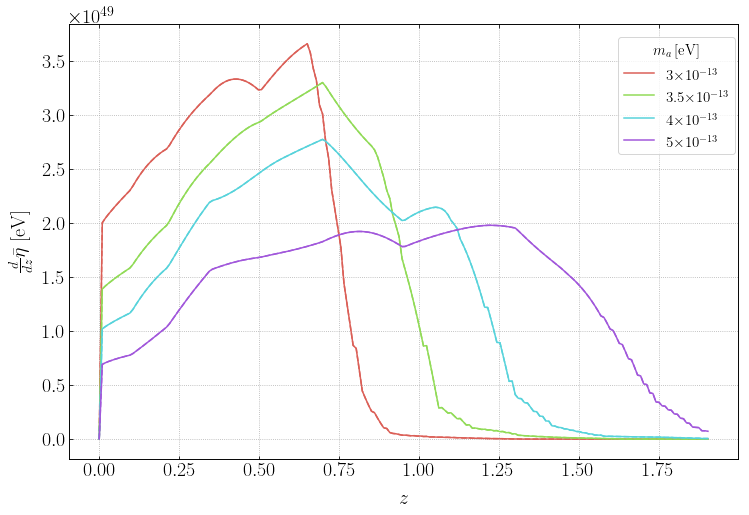

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
color_list = color_list = sns.color_palette("hls", len(MA_list)) #['red', 'green', 'blue', 'orange']
ax_mass = []

for i_MA in range(len(MA_list)):
    ax.plot(zs, dtau_list[0, i_MA]*ghztoev(30), ls='solid', label=r'B $\propto p$', c=color_list[i_MA])
    ax.plot(zs, dtau_list[1, i_MA]*ghztoev(30), ls='dashed', label=r'B = const', c=color_list[i_MA])
    #ll, = ax.plot(0,0, c=color_list[i_MA])
    #if i_MA==0:
    #    ax.legend(ncol=1, loc=[0.82, 0.85])

        
ax2 = ax.twinx()
for i_MA in range(len(MA_list)):
    ax2.plot(np.NaN, np.NaN, ls='-', label=r'{}'.format(fmt(MA_list[i_MA])), c=color_list[i_MA])
ax2.get_yaxis().set_visible(False)
#ax2.legend(loc=[0.82, 0.55], title=r'$m_a \, [{\rm eV}]$')
ax2.legend(loc=[0.82, 0.7], title=r'$m_a \, [{\rm eV}]$')

#ax.legend(handles=ax_mass, ['1', '2', '3'])
ax.set_ylabel(r'$\frac{d}{d z} \bar{\eta} \; [{\rm eV}]$')
ax.set_xlabel(r'$z$')
#ax.set_xscale('log'); 
#ax.set_yscale('log')

#ax.legend(ncol=1, loc=1, title=r'$m_a \, [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")
ax.grid(ls=':', color='darkgray', alpha=1)

#plt.savefig('./plots/dtaudz.pdf', rasterize=True)
plt.show()
